# Autotalker Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 07.12.2022
- **Date of Last Modification:** 07.12.2022

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [6]:
import itertools
import os
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

### 1.2 Configure Paths and Create Directories

In [7]:
# Define paths
figure_path = "../figures"
model_artefacts_path = "../model_artefacts"

gp_data_folder_path = "../datasets/gp_data/" # gene program data
srt_data_folder_path = "../datasets/srt_data/" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "omnipath_lr_interactions.csv"

# Create required directories
os.makedirs("mlruns", exist_ok=True)
os.makedirs(gp_data_folder_path, exist_ok=True)

### 1.3 Run Notebook Setup

In [8]:
# Define default matplotlib figure size
matplotlib.rcParams["figure.figsize"] = (5, 5)

In [9]:
# Ignore future warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [10]:
# Get time of notebook execution for timestamping saved artefacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [11]:
# Set random seed
random_seed = 42

### 1.4 Define Parameters

**Note:** ´edge_batch_size´ is a very important hyperparameter. Training does not work when it is too small because the gradients will be too noisy. If it is too high, you might run into GPU memory constraints.

In [12]:
## Dataset
dataset = "squidpy_seqfish_mouse_organogenesis"

## Model
# adata Keys
counts_key = "counts"
cell_type_key = "celltype_mapped_refined"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"

# Benchmark Loss Function Inclusions

## 2. Data

### 2.1 Load & Visualize Dataset

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


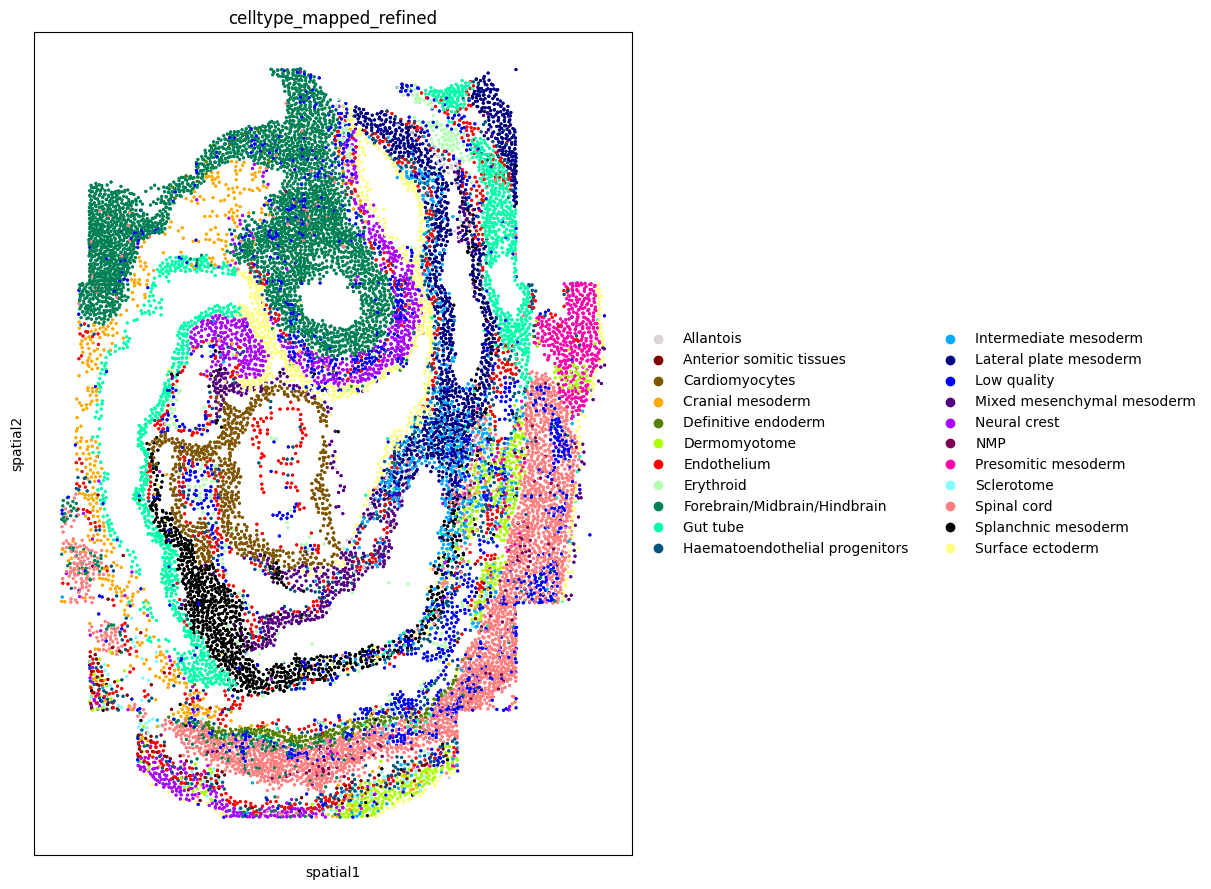

In [13]:
adata = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
sq.pl.spatial_scatter(adata, color=cell_type_key, shape=None, figsize=(12, 12))

## 3. Fine-Tuning of Loss Function with Fully Connected Gene Programs

In [14]:
experiment = mlflow.set_experiment("autotalker_benchmarking_1")

print("--- Dataset ---")
print(f"Using dataset {dataset}.")
mlflow.log_param("dataset", dataset)
n_nodes = adata.layers['counts'].shape[0]
n_genes = adata.layers['counts'].shape[1]
print(f"Number of nodes (cells): {n_nodes}")
print(f"Number of node features (genes): {n_genes}")
mlflow.log_param("n_nodes", n_nodes)
mlflow.log_param("n_genes", n_genes)

hyperparams = {}
hyperparams["n_neighs"] = [4, 8, 16, 32, 64]
hyperparams["n_latent_fc_gps"] = [32, 64, 128, 256, 512]
hyperparams["include_edge_recon_loss"] = [True, False]
hyperparams["lambda_edge_recon"] = [None]
hyperparams["include_gene_expr_recon_loss"] = [True, False]
hyperparams["lambda_gene_expr_recon"] = [1.]
hyperparams["node_label_method"] = ["self"]
hyperparams["gene_expr_recon_dist"] = ["nb"]
n_epochs = 10
lr = 0.01

# Loop through combination of hyperparams
iters = range(1)
keys, values = zip(*hyperparams.items())
for hyperparam_config in itertools.product(*values, iters):
    
    n_neighs = hyperparam_config[0]
    n_latent_fc_gps = hyperparam_config[1]
    include_edge_recon_loss = hyperparam_config[2]
    lambda_edge_recon = hyperparam_config[3]
    include_gene_expr_recon_loss = hyperparam_config[4]
    lambda_gene_expr_recon = hyperparam_config[5]
    node_label_method = hyperparam_config[6]
    gene_expr_recon_dist = hyperparam_config[7]

    # Create fully-connected mask that allows all latent dims to reconstruct all genes
    n_output = len(adata.var)
    gp_targets_mask = np.ones((n_latent_fc_gps, n_output))
    adata.uns[gp_names_key] = np.array([f"FC_GP_{i}" for i in range(n_latent_fc_gps)])

    # Determine dimensionality of hidden encoder
    n_hidden_encoder = int(n_latent_fc_gps/2)
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata,
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=n_neighs)
    mlflow.log_param("n_neighbors", n_neighs)
    
    print("")
    print("--- SPATIAL CONNECTIVITIES STATS ---")
    avg_edges_per_node = round(adata.obsp['spatial_connectivities'].sum(axis=0).mean(), 2)
    print(f"Average number of edges per node: {avg_edges_per_node}")
    n_edges = int(sp.triu(adata.obsp['spatial_connectivities'], k=1).sum())
    print(f"Number of total edges: {n_edges}", sep="")
    mlflow.log_param("n_edges", n_edges)

    print("")
    ### Model Training ###
    model = Autotalker(adata,
                       counts_key=counts_key,
                       adj_key=adj_key,
                       gp_names_key=gp_names_key,
                       active_gp_names_key=active_gp_names_key,
                       latent_key=latent_key,
                       include_edge_recon_loss=include_edge_recon_loss,
                       include_gene_expr_recon_loss=include_gene_expr_recon_loss,
                       gene_expr_recon_dist=gene_expr_recon_dist,
                       node_label_method=node_label_method,
                       n_hidden_encoder=n_hidden_encoder,
                       gp_targets_mask=gp_targets_mask,
                       gp_sources_mask=None,
                       n_addon_gps=0)
    
    print("")
    model.train(n_epochs=n_epochs,
                lr=lr,
                lambda_edge_recon=lambda_edge_recon,
                lambda_gene_expr_recon=lambda_gene_expr_recon,
                mlflow_experiment_id=experiment.experiment_id,
                verbose=True)
    
    model.run_benchmarks(adata=model.adata,
                         cell_type_key=cell_type_key,
                         spatial_key=spatial_key,
                         spatial_knng_key="autotalker_spatial_8nng",
                         latent_knng_key="autotalker_latent_8nng",
                         n_neighbors=n_neighs,
                         seed=random_seed,
                         mlflow_experiment_id=experiment.experiment_id)
    
    break

    model.save(dir_path=f"{model_artefacts_path}/{dataset}/autotalker_fc_gps_{current_timestamp}",
               overwrite=True,
               save_adata=True,
               adata_file_name=f"{dataset}.h5ad")
    
mlflow.end_run()

Using dataset squidpy_seqfish_mouse_organogenesis.
Number of nodes (cells): 19416
Number of node features (genes): 351

--- SPATIAL CONNECTIVITIES STATS ---
Average number of edges per node: 8.0
Number of total edges: 78058

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> self
ACTIVE GP THRESHOLD RATIO -> 0.0
GCN ENCODER -> n_input: 351, n_hidden: 64, n_latent: 128, n_addon_latent: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 128, n_addon_input: 0, n_output: 351

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of test nodes: 0
Number of training edges: 66351
Number of validation edges: 7805
Number of test edges: 3902

--- MODEL TRAINING ---
Epoch 1/10 |██------------------| 10.0% val_auroc_score: 0.9578; val_auprc_

KeyboardInterrupt: 

In [ ]:
model.adata.obsm['autotalker_latent']

In [ ]:
model.get_active_gps()

In [ ]:
model.active_gp_thresh_ratio_

In [ ]:
arclisi = compute_arclisi(model.adata, cell_type_key="celltype_mapped_refined")

## 4. Autotalker Model with Cell-Cell-Interaction (CCI) Gene Programs

### 4.1 OmniPath Ligand Receptor CCI Gene Programs

#### 4.1.1 Create OmniPath CCI Gene Program Mask

In [ ]:
# Load OmniPath ligand-receptor interactions into a gene program dictionary using the OmniPath Python API
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [ ]:
# Filter and combine OmniPath ligand receptor interaction gene programs
omnipath_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=omnipath_gp_dict,
    gp_filter_mode=None,
    combine_overlap_gps=True,
    overlap_thresh_source_genes=1.,
    overlap_thresh_target_genes=1.,
    overlap_thresh_genes=1.,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(omnipath_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(omnipath_new_gp_dict)}.")

In [ ]:
# Add the gene program dictionary as binary masks to the adata for model training
add_gps_from_gp_dict_to_adata(
    gp_dict=omnipath_new_gp_dict,
    adata=adata,
    genes_uppercase=True,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata.uns[gp_names_key])

In [ ]:
# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(list(adata.uns['autotalker_gp_names']), 5)}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_gp_sources'].sum()}.")

#### 4.1.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   include_edge_recon_loss=include_edge_recon_loss,
                   include_gene_expr_recon_loss=include_gene_expr_recon_loss,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   log_variational=log_variational,
                   node_label_method=node_label_method,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   n_hidden_encoder=n_hidden_encoder,
                   dropout_rate_encoder=dropout_rate_encoder,
                   dropout_rate_graph_decoder=dropout_rate_graph_decoder,
                   gp_targets_mask=None,
                   gp_sources_mask=None,
                   n_addon_gps=0)

In [ ]:
mlflow.end_run()
experiment = mlflow.set_experiment("autotalker_omnipath_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            n_epochs_no_edge_recon=n_epochs_no_edge_recon,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            weight_decay=weight_decay,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_group_lasso=lambda_group_lasso,
            lambda_l1_addon=lambda_l1_addon,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            node_batch_size=node_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

In [ ]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_omnipath_gps_{current_timestamp}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

### 4.2 NicheNet Ligand Target Gene CCI Gene Programs

#### 4.2.1 Create NicheNet CCI Gene Program Mask

In [ ]:
# Load Nichenet ligand target gene interactions into a gene program dictionary using the NicheNet web URL
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.01,
    load_from_disk=True,
    save_to_disk=True,
    file_path=nichenet_ligand_target_mx_file_path)

In [ ]:
# Filter and combine NicheNet ligand target gene interaction gene programs
nichenet_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=nichenet_gp_dict,
    gp_filter_mode=None,
    combine_overlap_gps=True,
    overlap_thresh_source_genes=1.,
    overlap_thresh_target_genes=1.,
    overlap_thresh_genes=1.,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(nichenet_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(nichenet_new_gp_dict)}.")

In [ ]:
# Add the gene program dictionary as binary masks to the adata for model training
add_gps_from_gp_dict_to_adata(
    gp_dict=nichenet_new_gp_dict,
    adata=adata,
    genes_uppercase=True,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata.uns[gp_names_key])

In [ ]:
# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(list(adata.uns['autotalker_gp_names']), 5)}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_gp_sources'].sum()}.")

#### 4.2.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   include_edge_recon_loss=include_edge_recon_loss,
                   include_gene_expr_recon_loss=include_gene_expr_recon_loss,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   log_variational=log_variational,
                   node_label_method=node_label_method,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   n_hidden_encoder=n_hidden_encoder,
                   dropout_rate_encoder=dropout_rate_encoder,
                   dropout_rate_graph_decoder=dropout_rate_graph_decoder,
                   gp_targets_mask=None,
                   gp_sources_mask=None,
                   n_addon_gps=0)

In [ ]:
mlflow.end_run()
experiment = mlflow.set_experiment("autotalker_nichenet_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            n_epochs_no_edge_recon=n_epochs_no_edge_recon,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            weight_decay=weight_decay,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_group_lasso=lambda_group_lasso,
            lambda_l1_addon=lambda_l1_addon,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            node_batch_size=node_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

In [ ]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_nichenet_gps_{current_timestamp}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

### 4.3 MEBOCOST Metabolite Enzyme Sensor CCI Gene Programs

#### 4.3.1 Create MEBOCOST CCI Gene Program Mask

In [ ]:
# Load MEBOCOST metabolite enzyme sensor gene interactions into a gene program dictionary
# using the data from the autotalker package
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(species="mouse",
                                                                 genes_uppercase=True)

In [ ]:
# Filter and combine MEBOCOST metabolite enzyme sensor gene interaction gene programs
mebocost_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=mebocost_gp_dict,
    gp_filter_mode=None,
    combine_overlap_gps=True,
    overlap_thresh_source_genes=1.,
    overlap_thresh_target_genes=1.,
    overlap_thresh_genes=1.,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(mebocost_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(mebocost_new_gp_dict)}.")

In [ ]:
# Add the gene program dictionary as binary masks to the adata for model training
add_gps_from_gp_dict_to_adata(
    gp_dict=mebocost_new_gp_dict,
    adata=adata,
    genes_uppercase=True,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata.uns[gp_names_key])

In [ ]:
# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(list(adata.uns['autotalker_gp_names']), 5)}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_gp_sources'].sum()}.")

#### 4.3.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   include_edge_recon_loss=include_edge_recon_loss,
                   include_gene_expr_recon_loss=include_gene_expr_recon_loss,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   log_variational=log_variational,
                   node_label_method=node_label_method,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   n_hidden_encoder=n_hidden_encoder,
                   dropout_rate_encoder=dropout_rate_encoder,
                   dropout_rate_graph_decoder=dropout_rate_graph_decoder,
                   gp_targets_mask=None,
                   gp_sources_mask=None,
                   n_addon_gps=0)

In [ ]:
mlflow.end_run()
experiment = mlflow.set_experiment("autotalker_mebocost_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            n_epochs_no_edge_recon=n_epochs_no_edge_recon,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            weight_decay=weight_decay,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_group_lasso=lambda_group_lasso,
            lambda_l1_addon=lambda_l1_addon,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            node_batch_size=node_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

In [ ]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_mebocost_gps_{current_timestamp}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

### 4.4 Combined Prior Knowledge CCI Gene Programs

#### 4.4.1 Create Combined Prior Knowledge CCI Gene Program Mask

In [ ]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.1,
    load_from_disk=True,
    save_to_disk=True,
    file_path=nichenet_ligand_target_mx_file_path)

In [ ]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [ ]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    species="mouse",
    genes_uppercase=True)

In [ ]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [ ]:
# Filter and combine combined gene interaction gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode=None, #"subset",
    combine_overlap_gps=False, #True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

In [ ]:
# Add the gene program dictionary as binary masks to the adata for model training
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    genes_uppercase=True,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata.uns[gp_names_key])

In [ ]:
# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(list(adata.uns['autotalker_gp_names']), 5)}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_gp_sources'].sum()}.")

#### 4.4.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   include_edge_recon_loss=include_edge_recon_loss,
                   include_gene_expr_recon_loss=include_gene_expr_recon_loss,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   log_variational=log_variational,
                   node_label_method=node_label_method,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   n_hidden_encoder=n_hidden_encoder,
                   dropout_rate_encoder=dropout_rate_encoder,
                   dropout_rate_graph_decoder=dropout_rate_graph_decoder,
                   gp_targets_mask=None,
                   gp_sources_mask=None,
                   n_addon_gps=0)

In [ ]:
mlflow.end_run()
experiment = mlflow.set_experiment("autotalker_combined_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            n_epochs_no_edge_recon=n_epochs_no_edge_recon,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            weight_decay=weight_decay,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_group_lasso=lambda_group_lasso,
            lambda_l1_addon=lambda_l1_addon,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            node_batch_size=node_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

In [ ]:
# Check number of active gene programs
model.adata.obsm["autotalker_latent"].shape

In [ ]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_combined_gps_{current_timestamp}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

### 4.5 Learn New CCI Gene Programs

In [ ]:
model = Autotalker.load(dir_path=f"./model_artefacts/{dataset}/autotalker_combined_gps_{current_timestamp}",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        n_addon_gps=10,
                        gp_names_key=gp_names_key,
                        freeze_non_addon_weights=True)

In [ ]:
mlflow.end_run()
experiment = mlflow.set_experiment("autotalker_combined_denovo_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            n_epochs_no_edge_recon=n_epochs_no_edge_recon,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            weight_decay=weight_decay,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_group_lasso=lambda_group_lasso,
            lambda_l1_addon=lambda_l1_addon,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            node_batch_size=node_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

In [ ]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_combined_denovo_gps_{current_timestamp}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

## 6. Analysis

In [ ]:
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

In [ ]:
active_gps

In [ ]:
# Use autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata, min_dist=0.3)

### 6.1 Cell-type Annotations in Physical and Latent Space

In [ ]:
# Create subplot of cell-type annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
title = fig.suptitle(t="Cell-type Annotations in Physical and Latent Space",
                     x=0.85,
                     y=0.925,
                     fontsize=20)
sc.pl.spatial(adata=model.adata,
              color=[cell_type_key],
              spot_size=0.03,
              title="Physical Space",
              ax=axs[0],
              show=False)
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           title="Latent Space",
           ax=axs[1],
           show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.225, 0.625))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig(f"figures/analysis/{dataset}/cell_type_annotations_in_physical_and_latent_space_{current_timestamp}.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

### 6.2 Latent Leiden Cluster Annotations in Latent and Physical Space

In [ ]:
model.compute_latent_graph_connectivities(adata=model.adata,
                                          n_neighbors=8,
                                          mode="knn",
                                          seed=random_seed)

In [ ]:
# Compute latent Leiden clustering
resolution = 0.3

sc.tl.leiden(adata=model.adata,
             resolution=resolution,
             random_state=random_seed,
             key_added=f"latent_leiden_{str(resolution)}",
             adjacency=model.adata.obsp["latent_connectivities"])

# Compute UMAP for latent Leiden clusters
sc.pp.neighbors(adata=model.adata, use_rep=latent_key)
sc.tl.umap(adata=model.adata, min_dist=0.3)

In [ ]:
# Create subplot of latent Leiden cluster annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
title = fig.suptitle(t="Latent Leiden Cluster Annotations in Latent and Physical Space",
                     x=0.85,
                     y=0.925,
                     fontsize=20)
sc.pl.umap(adata=model.adata,
           color=[f"latent_leiden_{str(resolution)}"],
           color_map="magma",
           title=f"Latent Space",
           ax=axs[0],
           show=False)
sc.pl.spatial(adata=model.adata,
              color=[f"latent_leiden_{str(resolution)}"],
              color_map="magma",
              spot_size=0.03,
              title=f"Physical Space",
              ax=axs[1],
              show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.025, 0.7))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig(f"figures/analysis/{dataset}/latent_leiden_cluster_annotations_in_latent_and_physical_space_{current_timestamp}.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

### 6.3 Gene Program Enrichments

#### 6.3.1 Cell-type Gene Program Enrichments

In [ ]:
differential_gp_scores_key = "autotalker_cell_type_differential_gp_scores"
n_top_up_gps = 6
n_top_down_gps = 6

##### 6.3.1.1 Explore All GPs Across All Categories

In [ ]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                                      adata=model.adata,
                                                      selected_gps=None,
                                                      selected_cats=None,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats="rest",
                                                      n_sample=1000,
                                                      key_added=differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

In [ ]:
# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

In [ ]:
# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

In [ ]:
fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Differential GP Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/differential_gp_scores_per_cell_type_all_categories_{current_timestamp}.png")
plt.show()

In [ ]:
top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()
top_genes = []

for gp in top_gps:
    top_genes.append(
        model.compute_gp_gene_importances(selected_gp=gp)["gene"][0])

In [ ]:
# Plot selected gene program latent scores
fig, axs = plt.subplots(nrows=n_top_up_gps+n_top_down_gps, ncols=3, figsize=(18, 4*len(top_gps)))
title = fig.suptitle(t="Differential GP Scores, Corresponding Cell-Types and Most Important GP Genes in Latent Space",
                     x=0.55,
                     y=0.96,
                     fontsize=20)
for i in range(len(top_gps)):
    sc.pl.umap(model.adata, color=top_gps[i], color_map="magma", ax=axs[i, 0], show=False)
    sc.pl.umap(model.adata,
               color=[cell_type_key],
               color_map="magma",
               groups=top_cats[i],
               ax=axs[i, 1],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    sc.pl.umap(model.adata,
               color=top_genes[i],
               color_map="binary",
               ax=axs[i, 2],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    
# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/cell_type_gp_scores_cell_types_most_important_genes_{current_timestamp}.png",
            bbox_extra_artists=(title,),
            bbox_inches="tight")
plt.show()

##### 6.3.1.2 Explore All GPs Across Specific Categories

In [ ]:
selected_cats = ["Erythroid", "Endothelium"]

In [ ]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                                      adata=model.adata,
                                                      selected_gps=None,
                                                      selected_cats=selected_cats,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats="rest",
                                                      n_sample=1000,
                                                      key_added=differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

In [ ]:
# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

In [ ]:
# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

In [ ]:
fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Differential GP Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/differential_gp_scores_per_cell_type_specific_categories_{current_timestamp}.png")
plt.show()

In [ ]:
top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()
top_genes = []

for gp in top_gps:
    top_genes.append(
        model.compute_gp_gene_importances(selected_gp=gp)["gene"][0])

In [ ]:
# Plot selected gene program latent scores
fig, axs = plt.subplots(nrows=n_top_up_gps+n_top_down_gps, ncols=3, figsize=(18, 4*len(top_gps)))
title = fig.suptitle(t="Differential GP Scores, Corresponding Cell-Types and Most Important GP Genes in Latent Space",
                     x=0.55,
                     y=0.96,
                     fontsize=20)
for i in range(len(top_gps)):
    sc.pl.umap(model.adata, color=top_gps[i], color_map="magma", ax=axs[i, 0], show=False)
    sc.pl.umap(model.adata,
               color=[cell_type_key],
               color_map="magma",
               groups=top_cats[i],
               ax=axs[i, 1],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    sc.pl.umap(model.adata,
               color=top_genes[i],
               color_map="binary",
               ax=axs[i, 2],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    
# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/cell_type_gp_scores_cell_types_most_important_genes_{current_timestamp}.png",
            bbox_extra_artists=(title,),
            bbox_inches="tight")
plt.show()

##### 6.3.1.3 Explore Specific GPs

In [ ]:
selected_gps = ["BMP7_ligand_receptor_GP", "EPOR_ligand_receptor_GP"]

In [ ]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                                      adata=model.adata,
                                                      selected_gps=selected_gps,
                                                      selected_cats=None,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats="rest",
                                                      n_sample=1000,
                                                      key_added=differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

In [ ]:
# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

In [ ]:
# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

In [ ]:
fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Differential GP Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/differential_gp_scores_per_cell_type_specific_gps_{current_timestamp}.png")
plt.show()

In [ ]:
top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()
top_genes = []

for gp in top_gps:
    top_genes.append(
        model.compute_gp_gene_importances(selected_gp=gp)["gene"][0])

In [ ]:
# Plot selected gene program latent scores
fig, axs = plt.subplots(nrows=n_top_up_gps+n_top_down_gps, ncols=3, figsize=(18, 4*len(top_gps)))
title = fig.suptitle(t="Differential GP Scores, Corresponding Cell-Types and Most Important GP Genes in Latent Space",
                     x=0.55,
                     y=0.96,
                     fontsize=20)
for i in range(len(top_gps)):
    sc.pl.umap(model.adata, color=top_gps[i], color_map="magma", ax=axs[i, 0], show=False)
    sc.pl.umap(model.adata,
               color=[cell_type_key],
               color_map="magma",
               groups=top_cats[i],
               ax=axs[i, 1],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    sc.pl.umap(model.adata,
               color=top_genes[i],
               color_map="binary",
               ax=axs[i, 2],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    
# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/cell_type_gp_scores_cell_types_most_important_genes_{current_timestamp}.png",
            bbox_extra_artists=(title,),
            bbox_inches="tight")
plt.show()

#### 6.3.2 Spatial Gene Program Enrichment Scores

#### 6.3.3 Gene Program Gene Importances

In [ ]:
selected_gp = ["BMP7_ligand_receptor_GP"]

In [ ]:
gene_importances_df = model.compute_gp_gene_importances(
    selected_gp="BMP7_ligand_receptor_GP",
    adata=None)

display(gene_importances_df)

In [ ]:
genes = list(gene_importances_df["gene"])

for gene in genes:
    sc.pl.umap(model.adata,
               color=gene,
               color_map="binary",
               legend_loc="on data",
               na_in_legend=False)